In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


analysing data

In [4]:
def missing_values_analysis(df):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (df[na_columns].isnull().sum() / df.shape[0]*100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss,np.round(ratio,2)],axis=1,keys=["missing values","ratio"])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(df, head=5, tail=5):
    print("Shape")
    print("rows: ", df.shape[0])
    print("columns: ",df.shape[1])
    print("------------------------------")
    print("Types")
    print(df.dtypes)
    print("")
    print("------------------------------")
    print(missing_values_analysis(df))
    print("------------------------------")
    print("duplicated values")
    print(df.duplicated().sum())
    print("------------------------------")
    print("quantiles")
    print(df.quantile([0,0.05,0.5,0.95,0.99,1]).T)

check_df(df)

Shape
rows:  4600
columns:  18
------------------------------
Types
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

------------------------------
Empty DataFrame
Columns: [missing values, ratio]
Index: []
------------------------------
duplicated values
0
------------------------------
quantiles
                 0.00      0.05           0.50       0.95        0.99  \
price             0.0  200000.0  460943.461539  1184050.0  2005220.00   
bedrooms          0.0       2.0       3.000000        5.0        6.00   
bathrooms         0.0       1.0       2.250000        3.5        4

In [5]:
#correlation between variables

correlation = df.corr()

<AxesSubplot:>

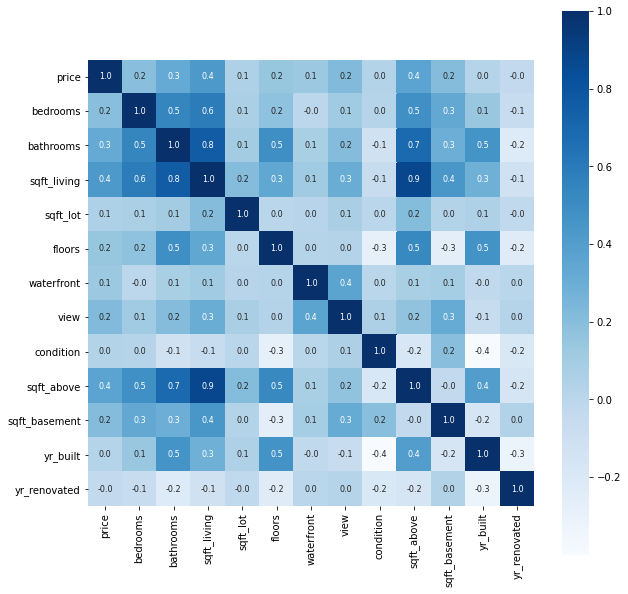

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cmap="Blues",annot=True,annot_kws={"size":8},  cbar=True, square=True,fmt=".1f")

pre processing

In [7]:
#Encoding Categorical Variables

# using label encoder to encode street by encoding the categorical variables into integer labels
categorical_variables = ["street","city","statezip","country"]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for var in categorical_variables:
    df[var] = label_encoder.fit_transform(df[var])

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,1522,36,62,0
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,3899,35,58,0
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,2291,18,26,0
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,4263,3,7,0
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,4352,31,31,0


In [8]:
#Feature Scaling

#using min-max scaling to scale the highly varying features into 0-1 scale

scale_features = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors","waterfront","view","condition","sqft_above","sqft_basement","yr_built","yr_renovated","street","city","statezip","country"]

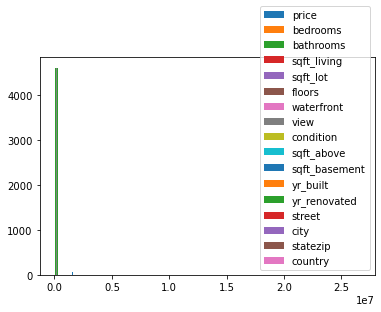

In [9]:
plt.hist(df[scale_features],70)
plt.legend(scale_features)
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for var in scale_features:
    df[var] =  scaler.fit_transform(df[[var]])
    
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,0.011771,0.333333,0.18750,0.073652,0.006775,0.2,0.0,0.0,0.50,0.107301,0.000000,0.482456,0.995531,0.336428,0.837209,0.815789,0.0
1,2014-05-02 00:00:00,0.089658,0.555556,0.31250,0.249051,0.007835,0.4,0.0,1.0,1.00,0.331858,0.058091,0.184211,0.000000,0.861848,0.813953,0.763158,0.0
2,2014-05-02 00:00:00,0.012862,0.333333,0.25000,0.118451,0.010534,0.0,0.0,0.0,0.75,0.172566,0.000000,0.578947,0.000000,0.506410,0.418605,0.342105,0.0
3,2014-05-02 00:00:00,0.015795,0.333333,0.28125,0.123766,0.006885,0.0,0.0,0.0,0.75,0.069690,0.207469,0.552632,0.000000,0.942308,0.069767,0.092105,0.0
4,2014-05-02 00:00:00,0.020684,0.444444,0.31250,0.119210,0.009186,0.0,0.0,0.0,0.75,0.085177,0.165975,0.666667,0.989076,0.961981,0.720930,0.407895,0.0


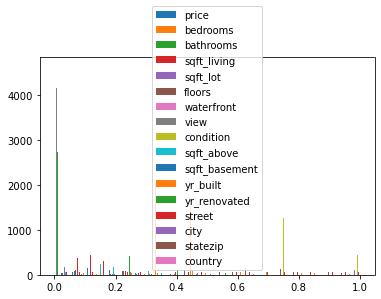

In [11]:
plt.hist(df[scale_features],70)
plt.legend(scale_features)
plt.show()

In [12]:
#Feature Selection

#removing highly correlated features (according to heatmap, sqft_living and sqft_above)
df = df.drop(["sqft_above"],axis=1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,0.011771,0.333333,0.18750,0.073652,0.006775,0.2,0.0,0.0,0.50,0.000000,0.482456,0.995531,0.336428,0.837209,0.815789,0.0
1,2014-05-02 00:00:00,0.089658,0.555556,0.31250,0.249051,0.007835,0.4,0.0,1.0,1.00,0.058091,0.184211,0.000000,0.861848,0.813953,0.763158,0.0
2,2014-05-02 00:00:00,0.012862,0.333333,0.25000,0.118451,0.010534,0.0,0.0,0.0,0.75,0.000000,0.578947,0.000000,0.506410,0.418605,0.342105,0.0
3,2014-05-02 00:00:00,0.015795,0.333333,0.28125,0.123766,0.006885,0.0,0.0,0.0,0.75,0.207469,0.552632,0.000000,0.942308,0.069767,0.092105,0.0
4,2014-05-02 00:00:00,0.020684,0.444444,0.31250,0.119210,0.009186,0.0,0.0,0.0,0.75,0.165975,0.666667,0.989076,0.961981,0.720930,0.407895,0.0


In [13]:
# seperating features from target
features = df.drop(columns=["date","price"])
target = df["price"]

In [14]:
features.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,0.333333,0.18750,0.073652,0.006775,0.2,0.0,0.0,0.50,0.000000,0.482456,0.995531,0.336428,0.837209,0.815789,0.0
1,0.555556,0.31250,0.249051,0.007835,0.4,0.0,1.0,1.00,0.058091,0.184211,0.000000,0.861848,0.813953,0.763158,0.0
2,0.333333,0.25000,0.118451,0.010534,0.0,0.0,0.0,0.75,0.000000,0.578947,0.000000,0.506410,0.418605,0.342105,0.0
3,0.333333,0.28125,0.123766,0.006885,0.0,0.0,0.0,0.75,0.207469,0.552632,0.000000,0.942308,0.069767,0.092105,0.0
4,0.444444,0.31250,0.119210,0.009186,0.0,0.0,0.0,0.75,0.165975,0.666667,0.989076,0.961981,0.720930,0.407895,0.0


In [15]:
target.head()

0    0.011771
1    0.089658
2    0.012862
3    0.015795
4    0.020684
Name: price, dtype: float64

In [16]:
# splitting features to train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,target, train_size=0.8,random_state=0)
print("Training size: ", len(X_train), " Test size: ", len(X_test))

Training size:  3680  Test size:  920


Training and evaluating the model

In [17]:
#function to train and predict the model, while measuring the time and accuracy of it using r squared error

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    # fit
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    # predict
    start = time()
    predictions_test = learner.predict(X_test) 
    predictions_train = learner.predict(X_train[:300]) 
    end = time()
    results['pred_time'] = end - start
    #results
    results['r2_train'] = metrics.r2_score(y_train[:300], predictions_train)
    results['r2_test'] = metrics.r2_score(y_test,predictions_test)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

In [18]:
#comparing 3 different regression models 

from time import time
import visualpython as vs
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

reg_A = LinearRegression()
reg_B = DecisionTreeRegressor()
reg_C = GradientBoostingRegressor()
samples_100 = int(len(y_train))
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)
results = {}
for reg in [reg_A, reg_B, reg_C]:
    reg_name = reg.__class__.__name__
    results[reg_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[reg_name][i] = train_predict(reg, samples, X_train, y_train, X_test, y_test)
#print(results)

for i in ["LinearRegression","DecisionTreeRegressor","GradientBoostingRegressor"]:
    res_df = pd.DataFrame(results[i])
    print()
    print(i)
    print(res_df)


Visual Python
LinearRegression trained on 36 samples.
LinearRegression trained on 368 samples.
LinearRegression trained on 3680 samples.
DecisionTreeRegressor trained on 36 samples.
DecisionTreeRegressor trained on 368 samples.
DecisionTreeRegressor trained on 3680 samples.
GradientBoostingRegressor trained on 36 samples.
GradientBoostingRegressor trained on 368 samples.
GradientBoostingRegressor trained on 3680 samples.

LinearRegression
                   0         1         2
train_time  0.017971  0.005003  0.005003
pred_time   0.120999  0.005997  0.003997
r2_train    0.144458  0.553202  0.541681
r2_test     0.303159  0.534083  0.554431

DecisionTreeRegressor
                   0         1         2
train_time  0.003150  0.004998  0.033998
pred_time   0.003853  0.004002  0.004001
r2_train   -0.280917  1.000000  1.000000
r2_test    -0.117551  0.156942 -4.794310

GradientBoostingRegressor
                   0         1         2
train_time  0.029000  0.094997  0.543001
pred_time   0.0

evaluation

In [19]:
#the best model seems to be linear regression on maximum sample size
#improving the model with feature importance


model = LinearRegression()
model.fit(X_train, y_train)

coefficients = model.coef_

feature_importance = dict(zip(X_train.columns, coefficients))
feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: abs(item[1]), reverse=True)}

for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")

sqft_living: 0.12127265816003542
sqft_lot: -0.028286022939149853
bathrooms: 0.019848576947954458
bedrooms: -0.01895805365636502
waterfront: 0.011140964992215606
yr_built: -0.009473515786141513
view: 0.007353858227968537
condition: 0.005220311882359885
city: 0.005098350472690016
statezip: -0.0036683442439334997
sqft_basement: -0.002921586687091847
floors: 0.00232691365617004
yr_renovated: 0.0006095185897418018
street: -1.6582288380787798e-06
country: 0.0


In [20]:
#dropping features with least importance

less_important_features = ["yr_renovated","street","country"]
X_train = X_train.drop(less_important_features,axis=1)
X_test = X_test.drop(less_important_features,axis=1)

In [21]:
#testing model again

train_predict(reg_A, samples_100, X_train, y_train, X_test, y_test) 

LinearRegression trained on 3680 samples.


{'train_time': 0.003966331481933594,
 'pred_time': 0.006003141403198242,
 'r2_train': 0.5430906292845246,
 'r2_test': 0.5542590223185653}